In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import re

#### 1. Loading data
Given the huge size of the dataset, we are loading first 500k reviews for the analysis.

In [3]:
reviews_df = pd.read_csv("yelp_review.csv", nrows=1000000)

#### 2. Data cleaning
To get the best results, we are cleaning up the `text` column of the reviews dataset to get rid of non-alphabetic characters.

In [4]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text) 
    return text

reviews_df['cleaned_text'] = reviews_df['text'].apply(clean_text)

#### 3. Data pre-processing
We are setting up the sentiment boundaries. Anything below 3 star is classified as negative and given value 0 and any reviews with 4 stars or more is classified as positive and given value 1. Anything in between is classified as None.

In summary:
- Stars >= 4: 1 - Positive review
- Starts <= 2: 0 - Negative review
- Else: None

Finally, all the reviews with above None values are removed as this is irrelevant in our further analysis.

In [5]:
reviews_df['sentiment'] = reviews_df['stars'].apply(lambda x: 0 if x <= 2 else (1 if x >= 4 else None))
reviews_df = reviews_df.dropna(subset=['sentiment'])

#### 4. Model training
Now a regression model is trained on the above data. The data is vectorized with TF-IDF vectorized before it is fed to the model for training.

In [6]:
X = reviews_df['cleaned_text']
y = reviews_df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

tfidf_vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

model = LogisticRegression(max_iter=1000, random_state=111)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000, random_state=111)

#### 5. Model evaluation
Once the model is trained, we have to evaluate the performance. 

              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90     44911
         1.0       0.96      0.97      0.97    132279

    accuracy                           0.95    177190
   macro avg       0.94      0.93      0.93    177190
weighted avg       0.95      0.95      0.95    177190



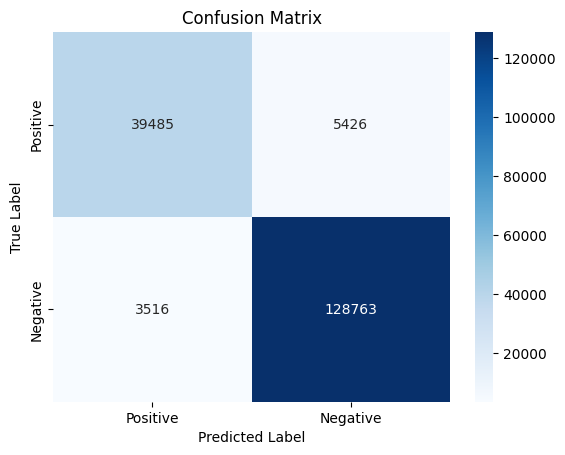

In [7]:
y_pred = model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

The model manages to produce a good accuracy score of 95%

#### Results
Now we have the predictions, we can have a quick look the most features 50 keywords in both positive and negative reviews.

Top 50 Positive Keywords:
[('superb', np.float64(5.535933187282698)), ('refreshing', np.float64(5.696996486184119)), ('reasonably', np.float64(5.9284651452638935)), ('happy', np.float64(5.95637770925917)), ('exceptional', np.float64(5.9917603293300825)), ('yum', np.float64(6.019345293265536)), ('easy', np.float64(6.04912749311361)), ('solid', np.float64(6.123771628324055)), ('heaven', np.float64(6.289145961060834)), ('downside', np.float64(6.308067338860514)), ('affordable', np.float64(6.309400950421775)), ('satisfied', np.float64(6.326601985658156)), ('professional', np.float64(6.3276504084159715)), ('fabulous', np.float64(6.397019986603076)), ('glad', np.float64(6.408945557247912)), ('disappoint', np.float64(6.518716986583683)), ('delish', np.float64(6.605140803686115)), ('helpful', np.float64(6.6137466270769885)), ('bomb', np.float64(6.733034006986989)), ('beat', np.float64(6.737902155573685)), ('reasonable', np.float64(6.898911700676639)), ('gem', np.float64(6.927394580313472)), ('

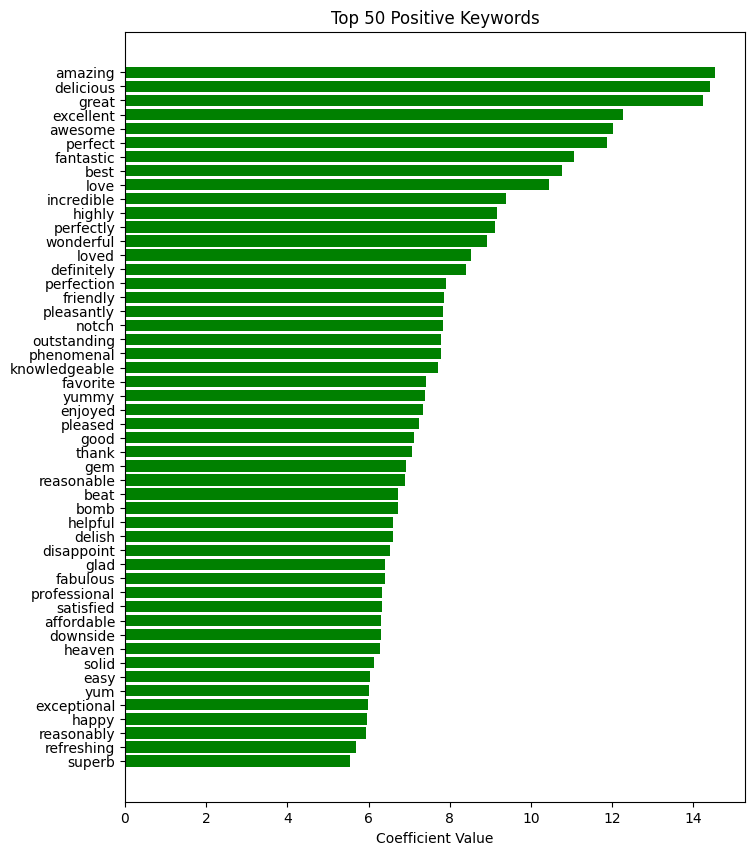

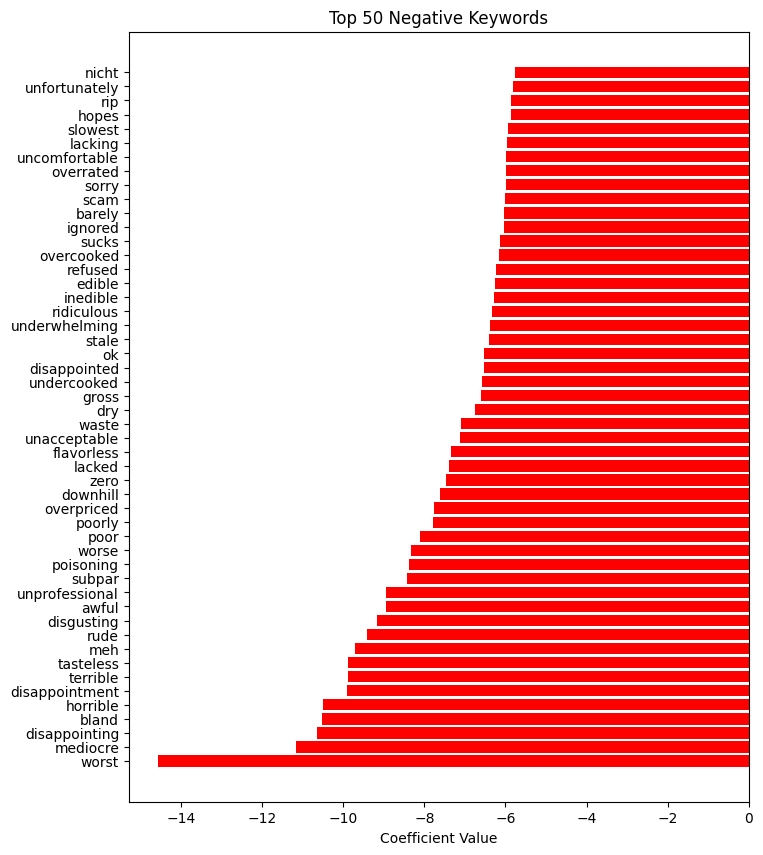

In [8]:
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
coefficients = model.coef_[0]

positive_indices = np.argsort(coefficients)[-50:]
negative_indices = np.argsort(coefficients)[:50] 

top_positive_keywords = feature_names[positive_indices]
top_negative_keywords = feature_names[negative_indices]

positive_scores = coefficients[positive_indices]
negative_scores = coefficients[negative_indices]

print("Top 50 Positive Keywords:")
print(list(zip(top_positive_keywords, positive_scores)))

print("\nTop 50 Negative Keywords:")
print(list(zip(top_negative_keywords, negative_scores)))

plt.figure(figsize=(8, 10))
plt.barh(top_positive_keywords, positive_scores, color='green')
plt.xlabel('Coefficient Value')
plt.title('Top 50 Positive Keywords')
plt.show()


plt.figure(figsize=(8, 10))
plt.barh(top_negative_keywords, negative_scores, color='red')
plt.xlabel('Coefficient Value')
plt.title('Top 50 Negative Keywords')
plt.show()
